In [19]:
from data_gen import generate_data
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [20]:
def extract_data(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Extract useful information from a given CloudFront DataFrame.

    Args:
        dataframe (pd.DataFrame): The DataFrame to extract information from. It should have columns 'date', 'time',
        'x_edge_location', 'c_ip', 'cs_method', 'sc_status', and 'cs_uri_stem'.

    Returns:
        pd.DataFrame: A new DataFrame containing only the useful information extracted from the input DataFrame. The
        new DataFrame has columns 'datetime', 'x_edge_location', 'c_ip', 'cs_method', 'sc_status', and 'cs_uri_stem'.
    """
    # merge date and time columns
    dataframe['datetime'] = pd.to_datetime(dataframe['date'] + ' ' + dataframe['time'])

    # drop the original date and time columns
    temp_df = dataframe.drop(['date', 'time'], axis=1, errors='ignore')

    # set datetime column as first column
    temp_df.insert(0, 'datetime', temp_df.pop('datetime'))

    # Extract useful information from df
    df = dataframe.loc[:, ['datetime', 'x_edge_location', 'c_ip', 'cs_method', 'sc_status', 'cs_uri_stem']]

    return df

In [21]:
from typing import Union

def find_unique_addresses(dataframe: pd.DataFrame) -> np.ndarray:
    """
    Returns an array of unique IP addresses from the given DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the CloudFront access log data.

    Returns:
    np.ndarray: An array of unique IP addresses found in the 'c_ip' column of the DataFrame.
    """
    return dataframe['c_ip'].unique()

def count_visits_per_ip(dataframe: pd.DataFrame, ip_address: str = None) -> Union[pd.core.series.Series, np.int64]:
    """ 
    Returns the number of visits per IP address in the given DataFrame.
    If an IP address is specified, returns the number of visits for that IP only.
    """
    if ip_address:
        return dataframe['c_ip'].value_counts().get(ip_address, 0)
    else:
        return dataframe['c_ip'].value_counts()


In [22]:
def pie_plot_head(dataframe: pd.DataFrame, top_by: str,  top_n: int = 10):
    if top_by not in dataframe:
        raise ValueError(f"Column {top_by} not in dataframe")
    top_n = min(len(dataframe[top_by]), top_n)
    if top_n == 0:
        raise ValueError(f"Column {top_by} is empty") 

    pd_series = dataframe[top_by].value_counts()
    title = f'Top {top_n} of {top_by} by count'

    plt.figure(title)
    plt.pie(pd_series.head(top_n), labels=pd_series.head(top_n).index, autopct='%1.1f%%')
    plt.title(title, y=1.08)
    plt.axis('equal')
    
    os.makedirs("figures", exist_ok=True)
    now = datetime.now().strftime('%d-%m-%y %H-%M-%S')
    img_path = str(Path("figures")/ f"{title} {now}.png")
    plt.savefig(img_path)

In [23]:
def show_edge_traffic(dataframe: pd.DataFrame, top_n: int = 10):
    """
    Displays a pie chart of the traffic distribution between the top N edge locations in the given DataFrame.

    Parameters:
    ----------
    dataframe : pd.DataFrame
        The DataFrame containing the CloudFront access log data.
    top_n : int, optional
        The number of top edge locations to display in the pie chart. Defaults to 10 and is limited to a maximum of 20.
    """
    pie_plot_head(dataframe, 'x_edge_location', top_n)

In [24]:
from urllib.parse import urljoin
import urllib.request
import json

def get_location(ip: str) -> str:
  """
  Retrieve the country associated with an IP address.

    Parameters:
    ip (str): The IP address to lookup.

    Returns:
    str: The country associated with the IP address, or 'Unknown' if no country information is available.
  """
  response = urllib.request.urlopen(urljoin('http://ipwho.is/', ip))
  ipwhois = json.load(response)

  return ipwhois.get('country', 'Unknown')

def plot_country_traffic(dataframe: pd.DataFrame, top_n: int = 10):
    """
    Plots a pie chart showing the distribution of traffic by country based on the given DataFrame.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        A pandas DataFrame containing CloudFront access log data.
    top_n : int, optional
        The number of top countries to display in the pie chart. Defaults to 10 and is limited to a maximum of 20.
    """
    if 'c_ip' not in dataframe:
        raise ValueError(f"Column c_ip not in dataframe")
    dataframe['location'] = dataframe['c_ip'].apply(get_location)

    pie_plot_head(dataframe, 'location', top_n)

In [25]:
def get_freq_endpoints(dataframe: pd.DataFrame, frequency = 100) -> pd.DataFrame:
    """
    Returns a DataFrame containing the endpoints that were visited more than a specified frequency,
    grouped by the HTTP status code, method, and endpoint.

    Parameters:
    ----------
    dataframe : pd.DataFrame
        The DataFrame containing the web access log data.
    frequency : int, optional
        The minimum number of times an endpoint must be visited to be included in the resulting DataFrame.
        Defaults to 100.

    Returns:
    -------
    pd.DataFrame
        A DataFrame containing the endpoints that were visited more than the specified frequency,
        grouped by the HTTP status code, method, and endpoint.
        The DataFrame has the following columns: 'sc_status', 'cs_method', 'cs_uri_stem', and 'count'.
    """
    if dataframe.empty:
        return pd.DataFrame()
    
    # group the data by sc_status, cs_method, and endpoint, and count the occurrences
    count_df = dataframe.groupby(['sc_status', 'cs_method', 'cs_uri_stem']).size().reset_index(name='count')

    # filter the dataframe to only include rows with count > freq
    result_df = count_df[count_df['count'] > frequency]

    # return the resulting dataframe
    return result_df

In [26]:
def check_brute_force(dataframe: pd.DataFrame, sigma: float = 3.5) -> list:
    """Checks for potential brute force attacks in a DataFrame of CloudFront logs.
    
    Parameters:
    daframe (pd.DataFrame): A pandas DataFrame containing the data to be analyzed.
    sigma (float): Says how many standard deviations of difference there must be to mark an IP 
    as source of brute force attack, ex. in case of sigma = 3.5 in theory only 1 bussiest per 5000 different IPs will be marked.
    """

    # Group the dataframe by endpoints and datetime
    grouped = dataframe.groupby(['cs_uri_stem', 'datetime'])

    # Create a sliding window of 5 minutes
    window_size = pd.Timedelta(minutes=5)
    windows = [grouped.filter(lambda x: ((x['datetime'] >= window_start) & (x['datetime'] < window_end)).any()).reset_index(drop=True)
               for window_start, window_end in zip(dataframe['datetime'], dataframe['datetime'] + window_size) 
               if not grouped.filter(lambda x: ((x['datetime'] >= window_start) & (x['datetime'] < window_end)).any()).empty]

    # Calculate the maximum count of requests for each window
    max_counts = [window.groupby('cs_uri_stem')['datetime'].count().max() for window in windows]

    req_count_stdev = np.sqrt(np.var(max_counts))
    req_count_avg = np.average(max_counts)
    threshold = req_count_avg + req_count_stdev * sigma

    # Flag any window with a maximum count exceeding threshold requests
    potential_attacks = [(window.iloc[0]['datetime'], window.iloc[-1]['datetime'])
                         for window, max_count in zip(windows, max_counts) if max_count > threshold]

    return potential_attacks

[]

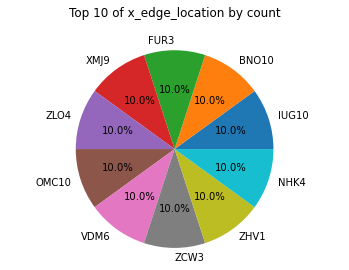

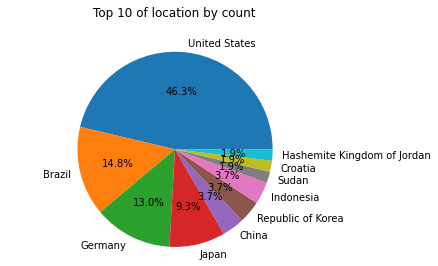

In [27]:
 # 1.
full_df = generate_data(50)
df = extract_data(full_df)

# 2.
unique_ips = find_unique_addresses(df)

# 3.
count_visits_per_ip(df)

# 4.
show_edge_traffic(df)

# 5.
plot_country_traffic(df)

# 6.
get_freq_endpoints(df, 20)

# 7.
check_brute_force(df)